# DISTILBERT Multilanguage

#### Configure NVIDIA GPU as Default

In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

Number of GPU:  1
GPU Name:  NVIDIA GeForce GTX 1650
GPU: NVIDIA GeForce GTX 1650 is available.


In [2]:
#Configure device: Set the device configuration to GPU using the torch.device class in PyTorch:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cuda


### Importing Library

In [3]:
import pandas as pd
import numpy as np

### Load Data

In [4]:
df = pd.read_csv('bca_preprocessed_half.csv', delimiter=',')
df.head(5)

,content,score,sentiment
0,pelayanan buruk trouble tidak ada info era dig...,1,0
1,kenapa sih ini verif aplikasinya susah banget ...,1,0
2,notifikasi transaksi tidak bisa di edit hapus ...,1,0
3,tidak bisa dibuka selalu force close talkback ...,1,0
4,ok bagus dan membantun,5,2


In [5]:
df.shape

(7000, 3)

### Find and clean missing data pt2

In [6]:
df.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [7]:
bca_clean_again = df.dropna()

In [8]:
bca_clean_again.isnull().sum()

content      0
score        0
sentiment    0
dtype: int64

In [9]:
bca_clean_again.shape

(7000, 3)

### Check Data Balance when Splitting🪓

In [10]:
#Split features (content) and labels (sentiment)

X = bca_clean_again['content']
y = bca_clean_again['sentiment']

In [11]:
# Check dataset balance and apply oversampling for "Neutral" class if needed
print("Before balancing:")
print(y.value_counts())

Before balancing:
sentiment
0    4181
2    2188
1     631
Name: count, dtype: int64


##### Melakukan balancing data karena kelas 0 mempunyai values yang sedikit dan dapat berpengaruh kepada performa yang tidak baik menggunakan Oversampling: duplikasi class minoritas untuk menyeimbangkan dataset.

In [12]:
# Oversampling technique
from sklearn.utils import resample


bca_clean_again = pd.concat([X, y], axis=1)

#separating each class

class_0 = bca_clean_again[bca_clean_again['sentiment'] == 0]
class_1 = bca_clean_again[bca_clean_again['sentiment'] == 1]
class_2 = bca_clean_again[bca_clean_again['sentiment'] == 2]

#oversampling neutral class 1 with majority class 2

class_1_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
class_2_oversampled = resample(class_2, replace=True, n_samples=len(class_0), random_state=42)

#combine all class
bca_clean_again = pd.concat([class_0, class_1_oversampled, class_2_oversampled])

#shuffling the data
bca_clean_again = bca_clean_again.sample(frac=1, random_state=42)

X = bca_clean_again['content']
y = bca_clean_again['sentiment']

In [13]:
# Check dataset balance and apply oversampling for "Neutral" class if needed
print("After balancing:")
print(y.value_counts())

After balancing:
sentiment
0    4181
2    4181
1    4181
Name: count, dtype: int64


### Splitting Data🪓🪓🪓 , 80:20 

In [14]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
#                                                     random_state=42, stratify=y)

# #split 20% test+validation into 10%test dan 10%validation
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
#                                                test_size=0.2, random_state=42)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

#split 20% test+validation into 10%test dan 10%validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                               test_size=0.5, random_state=42,stratify=y_temp)

In [15]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 10034
Validation set size: 1254
Test set size: 1255


#### Build Tokenizer with DistilBert-base-Multilingual-uncased

In [16]:
# import transformer library
from transformers import AutoTokenizer, DistilBertModel, DistilBertForSequenceClassification, DistilBertTokenizer, AutoModelForSequenceClassification

In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")

#### Convert Dataset to Hugging Face Format

In [18]:
from datasets import Dataset

def convert_dataset(X, y):
    return Dataset.from_pandas(pd.DataFrame({"text": X, "label": y}))

train_dataset = convert_dataset(X_train, y_train)
validation_dataset = convert_dataset(X_val, y_val)
test_dataset = convert_dataset(X_test, y_test)

label_map = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

print(train_dataset[0])

{'text': 'kecewa sekali kenapa sekarang selalu verivikasi data terusmenyusahkan saja', 'label': 0, '__index_level_0__': 6277}


#### Create tokenizer function

In [19]:
print(train_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 10034
})


In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

#apply tokenizer to datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset= test_dataset.map(tokenize_function, batched=True)

# Remove text column as it's no longer needed
train_dataset = train_dataset.remove_columns(["text"])
validation_dataset = validation_dataset.remove_columns(["text"])
test_dataset= test_dataset.remove_columns(["text"])

# Convert labels to int format
train_dataset = train_dataset.with_format("torch")
validation_dataset  = validation_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

Map:   0%|          | 0/10034 [00:00<?, ? examples/s]

Map:   0%|          | 0/1254 [00:00<?, ? examples/s]

Map:   0%|          | 0/1255 [00:00<?, ? examples/s]

In [21]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

#### Define Trainer and looping

In [22]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, EarlyStoppingCallback, AdamW, get_scheduler
# load model
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-multilingual-cased",
                                                           num_labels=3).to(device)

# enable gpu optimizations
torch.backends.cudnn.benchmark = True

model.gradient_checkpointing_enable()  # Reduces memory usage during training

training_args = TrainingArguments(
    output_dir='./distilbert_trainer_result',
    learning_rate=3e-5,
    num_train_epochs=5, #increase epochs
    per_device_train_batch_size=4, #train batch size
    per_device_eval_batch_size=4,  #eval batch size
    eval_strategy="epoch", # Evaluate model at the end of each epoch
    save_strategy="epoch",  # Set save_strategy to "epoch"
    eval_steps=500,
    warmup_steps=100,# increase learning rate every 100 steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    lr_scheduler_type="linear",
    fp16=False, #Gpu Optimization if capable yes, if not FALSE
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    gradient_accumulation_steps=2, #simulates larger batch size
    report_to="none", 
    max_grad_norm=1  # clips gradient to prevent explosions
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Darren\AppData\Local\Temp\ipykernel_33664\3774145117.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/6270 [00:00<?, ?it/s]

{'loss': 1.0787, 'grad_norm': 5.042455673217773, 'learning_rate': 3e-05, 'epoch': 0.08}
{'loss': 1.0094, 'grad_norm': 7.606345176696777, 'learning_rate': 2.9513776337115074e-05, 'epoch': 0.16}
{'loss': 0.946, 'grad_norm': 7.4939656257629395, 'learning_rate': 2.9027552674230147e-05, 'epoch': 0.24}
{'loss': 0.9085, 'grad_norm': 35.27448654174805, 'learning_rate': 2.854132901134522e-05, 'epoch': 0.32}
{'loss': 0.8716, 'grad_norm': 21.06980323791504, 'learning_rate': 2.8055105348460293e-05, 'epoch': 0.4}
{'loss': 0.8017, 'grad_norm': 9.231054306030273, 'learning_rate': 2.7568881685575363e-05, 'epoch': 0.48}
{'loss': 0.8154, 'grad_norm': 12.304648399353027, 'learning_rate': 2.708265802269044e-05, 'epoch': 0.56}
{'loss': 0.7642, 'grad_norm': 13.698321342468262, 'learning_rate': 2.6596434359805513e-05, 'epoch': 0.64}
{'loss': 0.7285, 'grad_norm': 19.8933048248291, 'learning_rate': 2.6110210696920583e-05, 'epoch': 0.72}
{'loss': 0.6993, 'grad_norm': 15.795405387878418, 'learning_rate': 2.56239

  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5541616082191467, 'eval_accuracy': 0.7783094098883573, 'eval_runtime': 10.8054, 'eval_samples_per_second': 116.053, 'eval_steps_per_second': 29.06, 'epoch': 1.0}
{'loss': 0.5596, 'grad_norm': 36.78740310668945, 'learning_rate': 2.4165316045380875e-05, 'epoch': 1.04}
{'loss': 0.4634, 'grad_norm': 22.5073184967041, 'learning_rate': 2.367909238249595e-05, 'epoch': 1.12}
{'loss': 0.4399, 'grad_norm': 2.0771987438201904, 'learning_rate': 2.319286871961102e-05, 'epoch': 1.2}
{'loss': 0.4678, 'grad_norm': 13.953669548034668, 'learning_rate': 2.2706645056726095e-05, 'epoch': 1.28}
{'loss': 0.384, 'grad_norm': 23.79184913635254, 'learning_rate': 2.2220421393841165e-05, 'epoch': 1.35}
{'loss': 0.409, 'grad_norm': 17.989072799682617, 'learning_rate': 2.173419773095624e-05, 'epoch': 1.43}
{'loss': 0.4284, 'grad_norm': 20.19340705871582, 'learning_rate': 2.1247974068071314e-05, 'epoch': 1.51}
{'loss': 0.3496, 'grad_norm': 24.251359939575195, 'learning_rate': 2.0761750405186384e-05, 

  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.3986365795135498, 'eval_accuracy': 0.8732057416267942, 'eval_runtime': 10.9264, 'eval_samples_per_second': 114.767, 'eval_steps_per_second': 28.738, 'epoch': 2.0}
{'loss': 0.227, 'grad_norm': 32.547237396240234, 'learning_rate': 1.7844408427876823e-05, 'epoch': 2.07}
{'loss': 0.2702, 'grad_norm': 263.1761169433594, 'learning_rate': 1.7358184764991896e-05, 'epoch': 2.15}
{'loss': 0.2249, 'grad_norm': 0.5042179226875305, 'learning_rate': 1.687196110210697e-05, 'epoch': 2.23}
{'loss': 0.2619, 'grad_norm': 131.53367614746094, 'learning_rate': 1.6385737439222043e-05, 'epoch': 2.31}
{'loss': 0.2492, 'grad_norm': 0.21270166337490082, 'learning_rate': 1.5899513776337116e-05, 'epoch': 2.39}
{'loss': 0.2115, 'grad_norm': 0.1252165138721466, 'learning_rate': 1.541329011345219e-05, 'epoch': 2.47}
{'loss': 0.2459, 'grad_norm': 0.10374912619590759, 'learning_rate': 1.492706645056726e-05, 'epoch': 2.55}
{'loss': 0.2193, 'grad_norm': 109.40351104736328, 'learning_rate': 1.4440842787682

  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5688123106956482, 'eval_accuracy': 0.8899521531100478, 'eval_runtime': 10.8224, 'eval_samples_per_second': 115.87, 'eval_steps_per_second': 29.014, 'epoch': 3.0}
{'loss': 0.1943, 'grad_norm': 5.178722381591797, 'learning_rate': 1.2009724473257698e-05, 'epoch': 3.03}
{'loss': 0.1399, 'grad_norm': 130.3580780029297, 'learning_rate': 1.1523500810372772e-05, 'epoch': 3.11}
{'loss': 0.1307, 'grad_norm': 15.403181076049805, 'learning_rate': 1.1037277147487844e-05, 'epoch': 3.19}
{'loss': 0.1264, 'grad_norm': 0.04053153097629547, 'learning_rate': 1.0551053484602917e-05, 'epoch': 3.27}
{'loss': 0.0894, 'grad_norm': 138.39405822753906, 'learning_rate': 1.0064829821717992e-05, 'epoch': 3.35}
{'loss': 0.2, 'grad_norm': 0.10175640136003494, 'learning_rate': 9.578606158833063e-06, 'epoch': 3.43}
{'loss': 0.1194, 'grad_norm': 0.3524123430252075, 'learning_rate': 9.092382495948137e-06, 'epoch': 3.51}
{'loss': 0.0861, 'grad_norm': 0.036267634481191635, 'learning_rate': 8.60615883306320

  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5393123626708984, 'eval_accuracy': 0.9114832535885168, 'eval_runtime': 11.0455, 'eval_samples_per_second': 113.531, 'eval_steps_per_second': 28.428, 'epoch': 4.0}
{'loss': 0.0849, 'grad_norm': 0.007900407537817955, 'learning_rate': 5.688816855753647e-06, 'epoch': 4.06}
{'loss': 0.1199, 'grad_norm': 103.0291519165039, 'learning_rate': 5.202593192868719e-06, 'epoch': 4.14}
{'loss': 0.1186, 'grad_norm': 230.8055877685547, 'learning_rate': 4.7163695299837925e-06, 'epoch': 4.22}
{'loss': 0.0684, 'grad_norm': 0.036827027797698975, 'learning_rate': 4.230145867098865e-06, 'epoch': 4.3}
{'loss': 0.0743, 'grad_norm': 0.014728770591318607, 'learning_rate': 3.7439222042139384e-06, 'epoch': 4.38}
{'loss': 0.0997, 'grad_norm': 0.2046666294336319, 'learning_rate': 3.257698541329011e-06, 'epoch': 4.46}
{'loss': 0.0681, 'grad_norm': 278.9290466308594, 'learning_rate': 2.7714748784440843e-06, 'epoch': 4.54}
{'loss': 0.0807, 'grad_norm': 12.752696990966797, 'learning_rate': 2.285251215559

  0%|          | 0/314 [00:00<?, ?it/s]

{'eval_loss': 0.5998344421386719, 'eval_accuracy': 0.9098883572567783, 'eval_runtime': 10.9235, 'eval_samples_per_second': 114.799, 'eval_steps_per_second': 28.745, 'epoch': 5.0}
{'train_runtime': 2071.5267, 'train_samples_per_second': 24.219, 'train_steps_per_second': 3.027, 'train_loss': 0.3350617194289796, 'epoch': 5.0}


TrainOutput(global_step=6270, training_loss=0.3350617194289796, metrics={'train_runtime': 2071.5267, 'train_samples_per_second': 24.219, 'train_steps_per_second': 3.027, 'total_flos': 1660375984674816.0, 'train_loss': 0.3350617194289796, 'epoch': 4.996412913511359})

#### Evaluate Model

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
from sklearn.metrics import accuracy_score

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(y_test, preds) *100

#print classification report
print("5 Epochs, LR 3e-5 fp16 False, train&eval batch size = 4, max_grad_norm = 1, gradient_accumulation= 2")
print(f"Test Accuracy: {accuracy:.2f}%\n")
print(classification_report(y_test, preds, target_names=list(label_map.values())))

  0%|          | 0/314 [00:00<?, ?it/s]

5 Epochs, LR 3e-5 fp16 False, train&eval batch size = 4, max_grad_norm = 1, gradient_accumulation= 2
Test Accuracy: 91.79%

              precision    recall  f1-score   support

    NEGATIVE       0.91      0.87      0.89       418
     NEUTRAL       0.92      0.99      0.96       418
    POSITIVE       0.92      0.90      0.91       419

    accuracy                           0.92      1255
   macro avg       0.92      0.92      0.92      1255
weighted avg       0.92      0.92      0.92      1255



##### Confusion Matrix

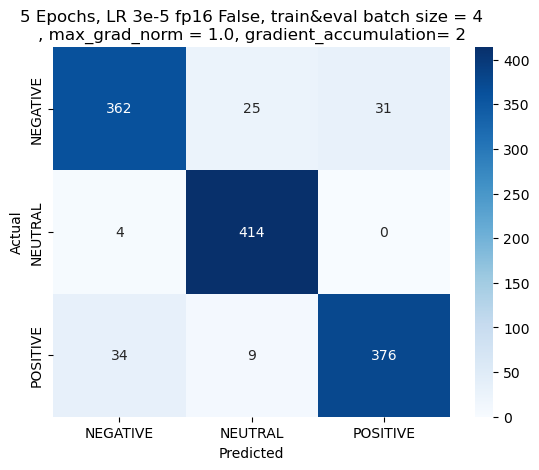

In [25]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=list(label_map.values()), yticklabels=list(label_map.values()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("5 Epochs, LR 3e-5 fp16 False, train&eval batch size = 4\n, max_grad_norm = 1.0, gradient_accumulation= 2")
plt.show()

#### Train and eval loss

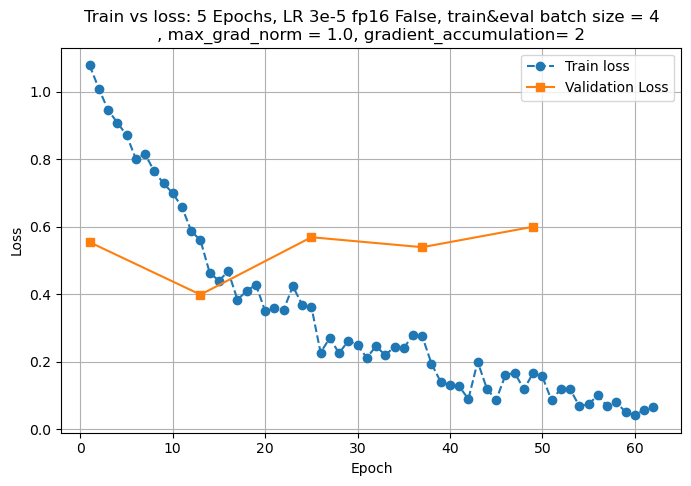

In [32]:
# Train and eval loss visualization

import matplotlib.pyplot as plt

train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Generate epochs in range
train_steps = list(range(1, len(train_loss) + 1))
eval_epochs = list(range(1, len(eval_loss) * (len(train_loss) // len(eval_loss)) + 1, len(train_loss) // len(eval_loss)))

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, label="Train loss", marker="o", linestyle="dashed")
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker="s")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs loss: 5 Epochs, LR 3e-5 fp16 False, train&eval batch size = 4\n, max_grad_norm = 1.0, gradient_accumulation= 2")
plt.legend()
plt.grid()
plt.show()


#### Improving Neutral Classification

In [40]:
def custom_predict(trainer, text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    # Get model predictions (logits)
    outputs = trainer.model(**tokens)
    logits = outputs.logits.detach().cpu().numpy()

    probs = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)

    preds = []
    for prob in probs:
        if 0.35 < prob[1] < 0.65:
            preds.append(1) #Neutral
        else:
            preds.append(np.argmax(prob))
    return [label_map[p]for p in preds]

# text example
texts = ['Aplikasinya biasa aja','A really good app for mobile banking', 'aplikasi jelek banyak virusnya']
print(custom_predict(trainer, texts))

['POSITIVE', 'POSITIVE', 'NEGATIVE']


In [27]:
def dynamic_neutral_threshold(logits):
    """
    Automatically calculate best neutral threshold
    """
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    # Get the average confidence of neutral class across all predictions
    neutral_probs = probs[:, 1] # Extract neutral class probabilities

    # Compute mean and standard deviation of neutral scores
    mean_neutral = np.mean(neutral_probs)
    std_neutral = np.std(neutral_probs)

    neutral_low = max(0.35, mean_neutral - 0.5 * std_neutral)
    neutral_high = min(0.65, mean_neutral + 0.5 * std_neutral)

    return neutral_low, neutral_high

def custom_predict(trainer,text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    # Get model predictions (logits)
    outputs = trainer.model(**tokens)
    logits = outputs.logits.detach().cpu().numpy()

    # Use softmax for stability
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

    # Get dynamic
    neutral_low, neutral_high = dynamic_neutral_threshold(logits)

    preds = []
    for prob in probs:
        if neutral_low < prob[1] < neutral_high:
            preds.append(1) #Neutral
        else:
            preds.append(np.argmax(prob)) #use highest probability

    return[label_map[p]for p in preds]

In [28]:
trainer.save_model("distilbert_finetuning_result")
tokenizer.save_pretrained("distilbert_finetuning_result")

('distilbert_finetuning_result\\tokenizer_config.json',
 'distilbert_finetuning_result\\special_tokens_map.json',
 'distilbert_finetuning_result\\vocab.txt',
 'distilbert_finetuning_result\\added_tokens.json',
 'distilbert_finetuning_result\\tokenizer.json')

#### Inference simple test using pipeline

In [32]:
# from transformers import pipeline

# classifier = pipeline("sentiment-analysis", model="distilbert1")

# #Inference on new texts
# texts = ["Transfer dana berjalan lancar, tetapi menambahkan rekening baru agak rumit."]
# predictions = classifier(texts)

# #print results
# for text, pred in zip(texts, predictions):
#     print(f"Text: {text}\nSentiment: {pred['label']} (Confidence: {pred['score']:.2f})")

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import numpy as np

model_name = "distilbert_finetuning_result"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer= AutoTokenizer.from_pretrained(model_name)

#define classifier
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None)

#label mapping
label_map = {"LABEL_0": "NEGATIVE", "LABEL_1": "NEUTRAL", "LABEL_2": "POSITIVE"}

#inference
texts = ["aplikasi yang menurut saya bisa dipakai namun tidak spesial"]
predictions = classifier(texts)

for text, scores in zip(texts, predictions):
    # Find best label with highest confidence
    best_pred = max(scores, key=lambda x: x['score'])
    best_label = label_map[best_pred['label']]

    print(f"Text: {text}\nSentiment: {best_label} ('Confidence': {best_pred['score']:.4f})")

Device set to use cuda:0


Text: aplikasi yang menurut saya bisa dipakai namun tidak spesial
Sentiment: NEGATIVE ('Confidence': 0.9991)


### Test on Dataset 

In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import numpy as np
import pandas as pd

model_name = "distilbert_finetuning_result"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer= AutoTokenizer.from_pretrained(model_name)

#define classifier
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, top_k=None)

#label mapping
label_map = {"LABEL_0": "NEGATIVE", "LABEL_1": "NEUTRAL", "LABEL_2": "POSITIVE"}

df = pd.read_csv("bca_preprocessed_data.csv")

df_sample = df.sample(n=30, random_state=20) #test 30 sample from test dataset

texts = df_sample["content"].tolist()
predictions = classifier(texts)

sentiment_results = []
confidence_scores = []

for scores in predictions:
    best_pred = max(scores, key=lambda x: x['score'])
    best_label = label_map[best_pred['label']]
    best_score = best_pred['score']

    sentiment_results.append(best_label)
    confidence_scores.append(round(best_score, 4))

df_sample["predictions"] = sentiment_results
df_sample["confidence_score"] = confidence_scores


# Select columns to show later
df_sample = df_sample[["content","confidence_score","predictions"]]

Device set to use cuda:0


In [33]:
df_sample.head(20)

,content,confidence_score,predictions
8398,eror mulu gmn pakenya,0.9992,NEGATIVE
12483,the ui looks like something from the earliest ...,0.9992,NEGATIVE
6909,nutup sendiri pake cara yg di info di review j...,0.9999,POSITIVE
2680,ini gimna udh ke sekian kalinya verifikasi ula...,0.9994,NEGATIVE
12784,simple fitur lengkap ui minimalis jarang error...,0.9999,POSITIVE
4207,ribet,0.9990,NEGATIVE
2002,woy bca ini apk masih busuk aje timbang vermuk...,0.9994,NEGATIVE
3168,kenapa di flazz sekarang nggak ada menu top up...,0.9999,POSITIVE
535,saya disuruh merveritifikasi ulang lalu saya l...,0.9994,NEGATIVE
9820,hey im sorry i cant open the application and a...,0.9999,NEUTRAL


#### Save to Pickle for Deployment

In [5]:
import pickle
import torch

from transformers import AutoModelForSequenceClassification, AutoTokenizer

#load trained model
model_name = "distilbert1"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

#save model
model_save_path = "model/distilbert_1_model3epoch.pkl"
tokenizer_save_path = "model/tokenizer_3epoch.pkl"

with open(model_save_path, "wb")as f:
    pickle.dump(model, f)

with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)

print("saved successfully✅")



saved successfully✅


In [6]:
print(type(tokenizer))  # It should be <class 'transformers.PreTrainedTokenizerFast'> or similar


<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>
